In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import numpy as np
import pandas as pd
import os 
import gc
import warnings
#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error




In [3]:

#TASK 1
train = pd.read_csv("../input/store-sales-time-series-forecasting/train.csv")

print(train.head())



   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


In [3]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


In [4]:
#Data Cleaning

# Convert date to datetime
train['date'] = pd.to_datetime(train['date'])

# Sort by date
train = train.sort_values('date')

# Check for missing values
print(train.isnull().sum())




id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [6]:
# Check duplicates
print(f"Duplicate rows: {train.duplicated().sum()}")


Duplicate rows: 0


In [5]:
#Generate descriptive statistics
# Basic statistics; mean, median and mode
print(train['sales'].describe())

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64


In [21]:
# Mean, Median, Mode
print("Mean Sales:", train['sales'].mean())
print("Median Sales:", train['sales'].median())
print("Mode Sales:", train['sales'].mode()[0])

Mean Sales: 357.7757491126188
Median Sales: 11.0
Mode Sales: 0.0


In [23]:


#Checking number of stores and families (categories):

print("Number of Stores:", train['store_nbr'].nunique())
print("Number of Product Families:", train['family'].nunique())


Number of Stores: 54
Number of Product Families: 33


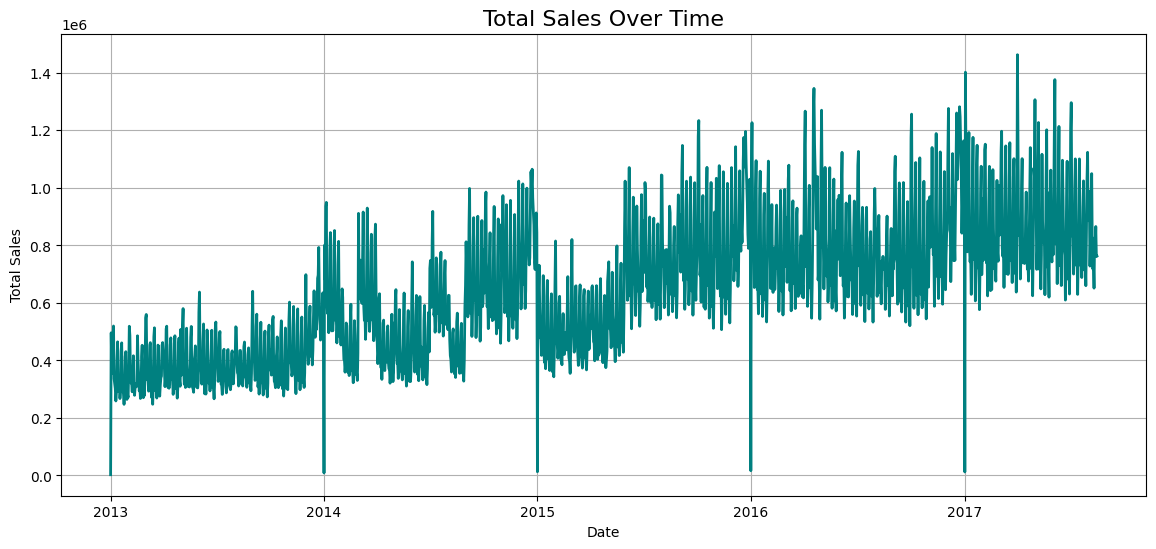

In [26]:
#Aggregate Daily Sales


daily_sales = train.groupby('date')['sales'].sum().reset_index()



#Visualize Sales Over Time (Line Chart)
plt.figure(figsize=(14,6))
plt.plot(daily_sales['date'], daily_sales['sales'], color='teal', linewidth=2)
plt.title("Total Sales Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

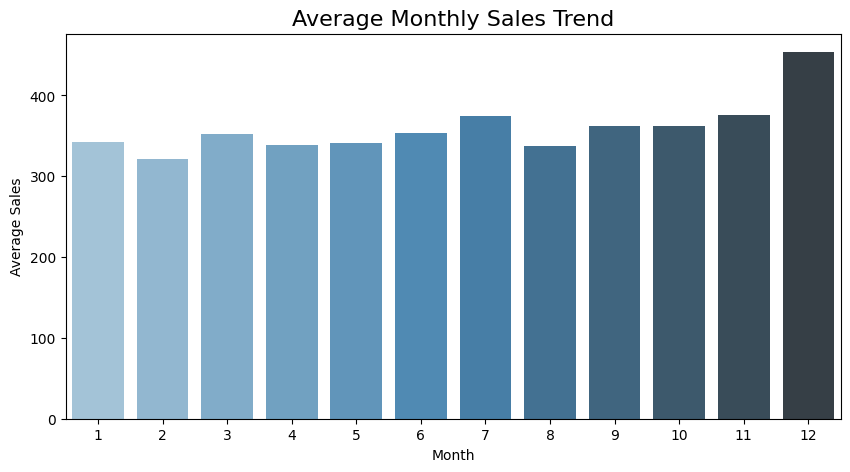

In [27]:
#Monthly Trends (Bar Chart)
#checking how average sales vary by month.

train['month'] = train['date'].dt.month
monthly_sales = train.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=monthly_sales, x='month', y='sales', palette='Blues_d')
plt.title("Average Monthly Sales Trend", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

#yearly overview
train['year'] = train['date'].dt.year
yearly_sales = train.groupby('year')['sales'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=yearly_sales, x='year', y='sales', palette='coolwarm')
plt.title("Total Sales by Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.show()


In [32]:
print("\n Task 1 Completed Successfully!")
print("The plot has been saved as 'model_output.png' in your project folder.")



 Task 1 Completed Successfully!
The plot has been saved as 'model_output.png' in your project folder.


In [30]:
#TASK 2

#Aggregate total daily sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()

print(daily_sales.head())

        date          sales
0 2013-01-01    2511.618999
1 2013-01-02  496092.417944
2 2013-01-03  361461.231124
3 2013-01-04  354459.677093
4 2013-01-05  477350.121229


In [39]:
# Shift MA to simulate forecast (predict next day)
daily_sales['Forecast_7day'] = daily_sales['7_day_MA'].shift(1)

# Calculate forecast error (Actual - Forecast)
daily_sales['Error'] = daily_sales['sales'] - daily_sales['Forecast_7day']

# Evaluate accuracy using Mean Absolute Error
mae = daily_sales['Error'].abs().mean()
print(f"Mean Absolute Error (7-day moving average): {mae:.2f}")


Mean Absolute Error (7-day moving average): 113793.63


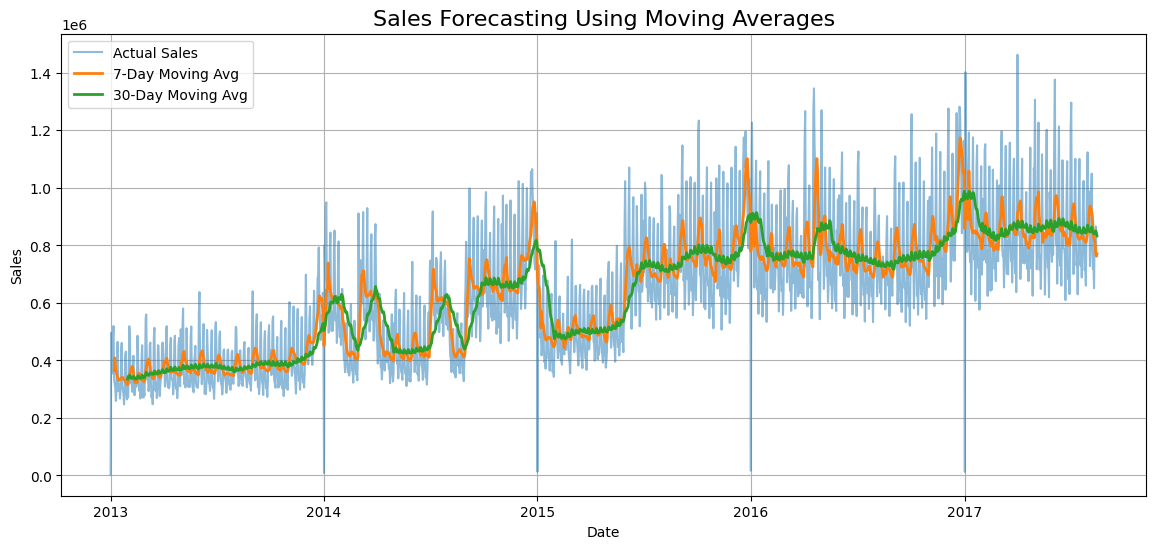

In [32]:
#TREND LINES Calculate 
daily_sales['7_day_MA'] = daily_sales['sales'].rolling(window=7).mean()
daily_sales['30_day_MA'] = daily_sales['sales'].rolling(window=30).mean()
plt.figure(figsize=(14,6))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Actual Sales', alpha=0.5)
plt.plot(daily_sales['date'], daily_sales['7_day_MA'], label='7-Day Moving Avg', linewidth=2)
plt.plot(daily_sales['date'], daily_sales['30_day_MA'], label='30-Day Moving Avg', linewidth=2)
plt.title("Sales Forecasting Using Moving Averages", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


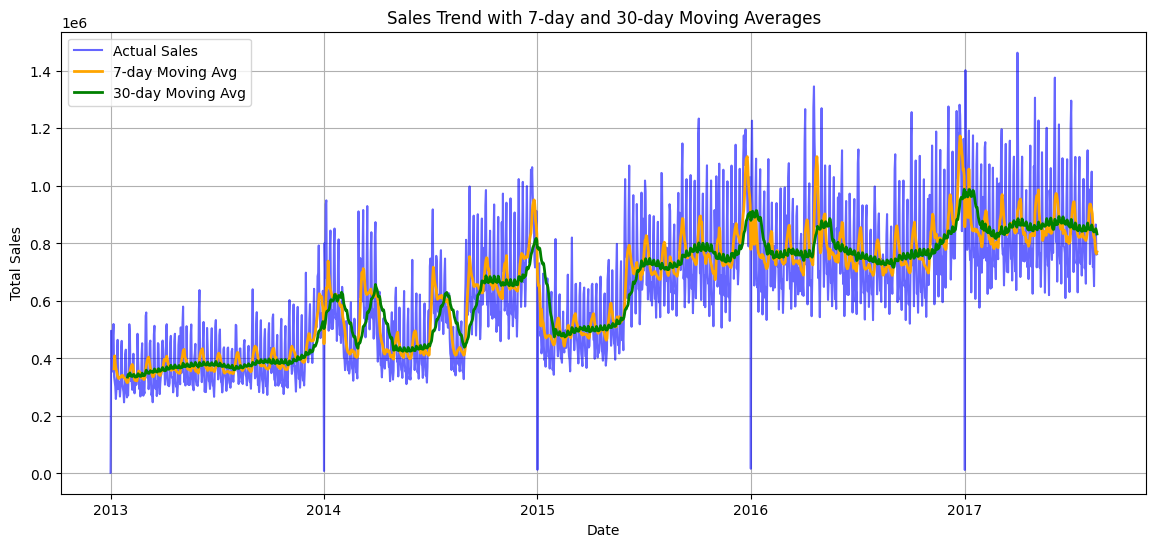

In [38]:
#Plot Actual Sales vs Moving Average
# By Creating Forecast from Moving Average
# shifting  the moving average by 1 day to simulate forecasting for the next day.

plt.figure(figsize=(14,6))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Actual Sales', color='blue', alpha=0.6)
plt.plot(daily_sales['date'], daily_sales['7_day_MA'], label='7-day Moving Avg', color='orange', linewidth=2)
plt.plot(daily_sales['date'], daily_sales['30_day_MA'], label='30-day Moving Avg', color='green', linewidth=2)
plt.title('Sales Trend with 7-day and 30-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
print("\n Task 2 Completed Successfully!")
print("The plot has been saved as 'model_output.png' in your project folder.")



 Task 2 Completed Successfully!
The plot has been saved as 'model_output.png' in your project folder.


In [12]:
# task 3: Convert to datetime

train['date'] = pd.to_datetime(train['date'])

# Step 2: Extract year, month, day, day of week
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   year         int32         
 7   month        int32         
 8   day          int32         
 9   day_of_week  int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(3), object(1)
memory usage: 183.2+ MB


In [5]:
# Calculate 7-day moving average
daily_sales['7_day_MA'] = daily_sales['sales'].rolling(window=7).mean()

# Shift MA to simulate forecast (predict next day)
daily_sales['Forecast_7day'] = daily_sales['7_day_MA'].shift(1)

# Calculate forecast error (Actual - Forecast)
daily_sales['Error'] = daily_sales['sales'] - daily_sales['Forecast_7day']

# Evaluate accuracy using Mean Absolute Error
mae = daily_sales['Error'].abs().mean()
print(f"Mean Absolute Error (7-day moving average): {mae:.2f}")


NameError: name 'daily_sales' is not defined

In [15]:
# Extract date features
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek

# Keep relevant columns
train = train[['sales', 'onpromotion', 'year', 'month', 'day', 'day_of_week']]


In [17]:
#Define Features (X) and Target (y)

X = train[['year', 'month', 'day', 'day_of_week', 'onpromotion']]
y = train['sales']

#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}\n")



Training samples: 2400710
Testing samples: 600178



In [20]:
#Build and Train Linear Regression Model

model = LinearRegression()
model.fit(X_train, y_train)




LinearRegression()

In [22]:
print(" Model Training Complete\n")


 Model Training Complete



In [24]:
#Making Predictions

y_pred = model.predict(X_test)

In [27]:
#Evaluate Model Performance,
# Let Mean Absolute Error be mae'
# Let  Root Mean Squared Error be rmse.

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f" Mean Absolute Error (MAE): {mae:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}\n")


 Mean Absolute Error (MAE): 434.62
 Root Mean Squared Error (RMSE): 1006.82



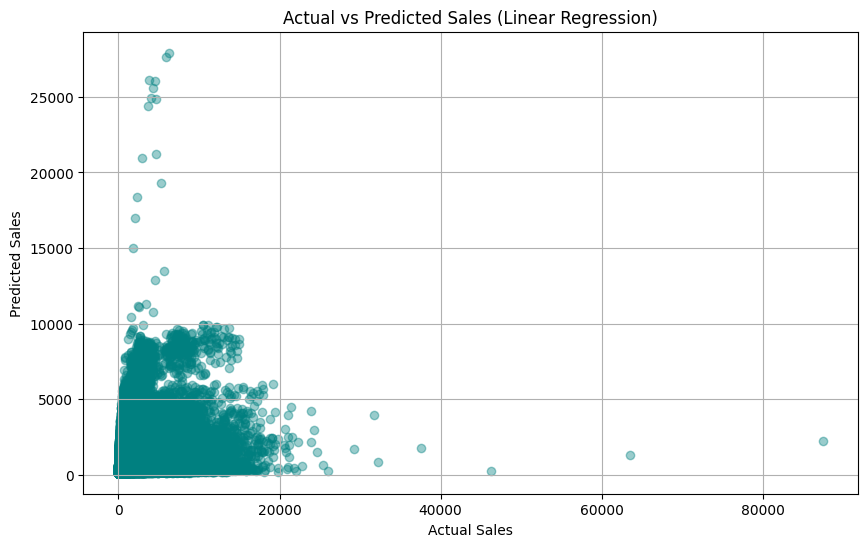

In [28]:
 #Visualize Actual vs Predicted Sales

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales (Linear Regression)")
plt.grid(True)
plt.savefig("model_output.png")
plt.show()


In [29]:
#Check Feature Importance (Coefficients)

coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("Feature Importance:")
print(coeff_df)

Feature Importance:
             Coefficient
year           -2.479866
month           2.765998
day            -1.599625
day_of_week    20.754172
onpromotion    38.513691


In [30]:
print("\n Task 3 Completed Successfully!")
print("The plot has been saved as 'model_output.png' in your project folder.")



 Task 3 Completed Successfully!
The plot has been saved as 'model_output.png' in your project folder.
